In [14]:
import torch
import triton
import triton.backends
import triton.language as tl
import math
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
triton.__version__

'3.2.0'

# sglang
- 去凑成MQA的形式，num_kv_head = 1

In [15]:
# def forward_absorb(self,positions: torch.Tensor,hidden_states: torch.Tensor,forward_batch: ForwardBatch) -> torch.Tensor:
#     q_len = hidden_states.shape[0]
#     q_input = hidden_states.new_empty(q_len, self.num_local_heads, self.kv_lora_rank + self.qk_rope_head_dim)
    
#     q = self.q_a_proj(hidden_states)[0]
#     q = self.q_a_layernorm(q)
#     q = self.q_b_proj(q)[0].view(-1, self.num_local_heads, self.qk_head_dim)
#     q_nope, q_pe = q.split([self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1)
#     # 把q_nope吸收w_kc，类似传统mha的 Q @ K^T  =  X @ Wq @ (X @ Wk)^T  =  (X @ Wq @ Wk^T) @ X^T
#     q_nope_out = torch.bmm(q_nope.transpose(0, 1), self.w_kc) 
#     q_input[..., : self.kv_lora_rank] = q_nope_out.transpose(0, 1)# q的前一部分包括吸了w_kc的q_nope1

#     latent_cache = self.kv_a_proj_with_mqa(hidden_states)[0] 
#     v_input = latent_cache[..., : self.kv_lora_rank] # hf中的compressed_kv, weight @ V = weight @ X @ w_v，相当于把x拿出来当v
#     v_input = self.kv_a_layernorm(v_input.contiguous()).unsqueeze(1) # 加一个head维度
#     k_input = latent_cache.unsqueeze(1)   # 加一个head维度
#     k_input[..., : self.kv_lora_rank] = v_input  # 把前面替换为经过norm的compressed_kv
#     k_pe = k_input[..., self.kv_lora_rank :]

#     q_pe, k_pe = self.rotary_emb(positions, q_pe, k_pe)
#     q_input[..., self.kv_lora_rank :] = q_pe   # 替换q和k带rope的地方
#     k_input[..., self.kv_lora_rank :] = k_pe

#     # MQA，attn_mqa中forward的时候，会把k_input给cache起来，包括compressed_kv和k_pe, v_input不需要cache
#     attn_output = self.attn_mqa(q_input, k_input, v_input, forward_batch)
#     attn_output = attn_output.view(-1, self.num_local_heads, self.kv_lora_rank)

#     attn_bmm_output = torch.bmm(attn_output.transpose(0, 1), self.w_vc)  # 乘上开始没乘的矩阵w_v
#     attn_output = attn_bmm_output.transpose(0, 1).flatten(1, 2) 
#     output, _ = self.o_proj(attn_output)

#     return output

# torch code

In [ ]:
def torch_mqa(q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, scale=None, attention_mask:torch.Tensor=None):
    attn_score = torch.matmul(q, k.transpose(-1, -2)) * scale
    B, H, N, _ = q.shape
    M = k.size(-2)
    if N > 1:
        assert N == M
        causal_mask = torch.ones(N, M, device=q.device).tril()[None, None, :, :].bool()
        if attention_mask is not None:
            attention_mask = causal_mask & attention_mask[:, None, None, :].bool()
        else:
            attention_mask = causal_mask
        attn_score.masked_fill_(~attention_mask, -65000)
    else:
        if attention_mask is not None:
            attention_mask = attention_mask[:, None, None, :].bool()
            attn_score.masked_fill_(~attention_mask, -65000)
    attn_weight = torch.nn.functional.softmax(attn_score, dim=-1, dtype=torch.float32).to(q.dtype)
    out = torch.matmul(attn_weight, v)
    return out

In [ ]:
def torch_mqa(q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, scale=None, attention_mask:torch.Tensor=None, decode_one_by_one=False):
    B, H, N, _ = q.shape
    M = k.size(-2)
    if N > 1:
        assert N == M
        attn_score = torch.matmul(q, k.transpose(-1, -2)) * scale
        causal_mask = torch.ones(N, M, device=q.device).tril()[None, None, :, :].bool()
        if attention_mask is not None:
            attention_mask = causal_mask & attention_mask[:, None, None, :].bool()
        else:
            attention_mask = causal_mask
        attn_score.masked_fill_(~attention_mask, -65000)
        attn_weight = torch.nn.functional.softmax(attn_score, dim=-1, dtype=torch.float32).to(q.dtype)
        out = torch.matmul(attn_weight, v)
        
    else:
        if attention_mask is not None:
            attention_mask = attention_mask[:, None, None, :].bool()

        if decode_one_by_one:
            out = torch.empty(B, H, N, v.size(-1), device=q.device, dtype=q.dtype)
            for idx in range(B):
                attn_score = torch.matmul(q[idx], k[idx].transpose(-1, -2)) * scale
                if attention_mask is not None:
                    attn_score.masked_fill_(~attention_mask[idx], -65000)
                attn_weight = torch.nn.functional.softmax(attn_score, dim=-1, dtype=torch.float32).to(q.dtype)
                out[idx] = torch.matmul(attn_weight, v[idx])

        else:
            attn_score = torch.matmul(q, k.transpose(-1, -2)) * scale
            if attention_mask is not None:
                attention_mask = attention_mask[:, None, None, :].bool()
                attn_score.masked_fill_(~attention_mask, -65000)
            attn_weight = torch.nn.functional.softmax(attn_score, dim=-1, dtype=torch.float32).to(q.dtype)
            out = torch.matmul(attn_weight, v)
    return out

# triton code

In [18]:
# @triton.autotune([triton.Config({'BLOCK_SIZE_N': bsn, 'BLOCK_SIZE_M': bsm}, num_stages=ns, num_warps=nw)
#                  for bsm in [32, 64]
#                  for bsn in [32, 64]
#                  for ns in [2, 4]
#                  for nw in [4, 8]
#                  ], key=['N', 'KV_LORA_RANK', 'ROPE_HEAD_DIM'])
@triton.jit
def _mla_encode_kernel(Q, K, V, OUT, 
                    NUM_PADS, SCALE,
                    q_stride_b, q_stride_h, q_stride_n, q_stride_d,
                    k_stride_b, k_stride_m, k_stride_d,
                    v_stride_b, v_stride_m, v_stride_d,
                    out_stride_b, out_stride_h, out_stride_n, out_stride_d,
                    N, KV_LORA_RANK: tl.constexpr, ROPE_HEAD_DIM: tl.constexpr,
                    BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_M: tl.constexpr
                    ):
    off_b = tl.cast(tl.program_id(0), tl.int64)
    off_h = tl.cast(tl.program_id(1), tl.int64)
    off_n = tl.cast(tl.program_id(2), tl.int64) * BLOCK_SIZE_N

    
    NUM_PADS += off_b
    num_pads = tl.cast(tl.load(NUM_PADS), tl.int64)

    if (off_n + BLOCK_SIZE_N) > num_pads:
        Q += off_b * q_stride_b + off_h * q_stride_h + off_n * q_stride_n
        K += off_b * k_stride_b + num_pads * k_stride_m
        V += off_b * v_stride_b
        OUT += off_b * out_stride_b + off_h * out_stride_h + off_n * out_stride_n

        nn = tl.arange(0, BLOCK_SIZE_N)
        mm = tl.arange(0, BLOCK_SIZE_M)
        
        dtype = Q.type.element_ty
    
        q_nope_ptrs = Q + nn[:, None] * q_stride_n + tl.arange(0, KV_LORA_RANK)[None, :]
        q_rope_ptrs = Q + nn[:, None] * q_stride_n + tl.arange(0, ROPE_HEAD_DIM)[None, :] + KV_LORA_RANK
        k_nope_ptrs = K + mm[None, :] * k_stride_m + tl.arange(0, KV_LORA_RANK)[:, None]
        k_rope_ptrs = K + mm[None, :] * k_stride_m + tl.arange(0, ROPE_HEAD_DIM)[:, None] + KV_LORA_RANK
        
        mask_n = (off_n + nn) < N
        q_nope = tl.load(q_nope_ptrs, mask=mask_n[:, None], other=0.) # q_nope是q的前kv_lora_rank维度
        q_rope = tl.load(q_rope_ptrs, mask=mask_n[:, None], other=0.)
        acc = tl.zeros((BLOCK_SIZE_N, KV_LORA_RANK), dtype=tl.float32)
        m_i = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32) - float('inf')
        l_i = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
        for start_m in range(num_pads, off_n + BLOCK_SIZE_N, BLOCK_SIZE_M): 
            mask_m = (start_m + mm) < N
            k_nope = tl.load(k_nope_ptrs, mask=mask_m[None, :], other=0.)
            k_rope = tl.load(k_rope_ptrs, mask=mask_m[None, :], other=0.) # k_nope是k的前kv_lora_rank维度

            attn_score= tl.dot(q_rope, k_rope)
            attn_score = tl.dot(q_nope, k_nope, acc=attn_score) * SCALE
            
            attn_mask = (off_n + nn)[:, None] >= (start_m + mm)[None, :]
            attn_score = tl.where(attn_mask & mask_m[None, :], attn_score, -60000)

            m_ij = tl.max(attn_score, axis=1)
            new_m_i = tl.maximum(m_i, m_ij)
            alpha = tl.exp(m_i - new_m_i)

            exp_attn_score = tl.exp(attn_score - new_m_i[:, None])

            l_i = l_i * alpha + tl.sum(exp_attn_score, axis=-1)
            acc = acc * alpha[:, None]
            # v就是compressed_kv，就是k的前kv_lora_rank维，也就是k_nope
            acc = tl.dot(exp_attn_score.to(dtype), tl.trans(k_nope, 1,0), acc=acc)

            m_i = new_m_i
            k_nope_ptrs += BLOCK_SIZE_M * k_stride_m
            k_rope_ptrs += BLOCK_SIZE_M * k_stride_m
        acc = acc / l_i[:, None]

        out_ptrs = OUT + nn[:, None] * out_stride_n + tl.arange(0, KV_LORA_RANK)[None, :]
        tl.store(out_ptrs, acc.to(dtype), mask=mask_n[:, None])
    else:
        pass


# @triton.autotune([triton.Config({'BLOCK_SIZE_M': bsn, 'BLOCK_SIZE_H': bsh}, num_stages=ns, num_warps=nw)
#                  for bsn in [32, 64, 128]
#                  for bsh in [16,32]
#                  for ns in [1, 2, 4]
#                  for nw in [4, 8]
#                  ], key=['M', 'KV_LORA_RANK', 'ROPE_HEAD_DIM'])
@triton.jit
def _mla_decode_kernel(Q, K, V, OUT, 
                    NUM_PADS, SCALE,
                    q_stride_b, q_stride_h, q_stride_n, q_stride_d,
                    k_stride_b, k_stride_m, k_stride_d,
                    v_stride_b, v_stride_m, v_stride_d,
                    out_stride_b, out_stride_h, out_stride_n, out_stride_d,
                    M, H, KV_LORA_RANK: tl.constexpr, ROPE_HEAD_DIM: tl.constexpr,
                    BLOCK_SIZE_H: tl.constexpr, BLOCK_SIZE_M: tl.constexpr
                    ):
    off_b = tl.cast(tl.program_id(0), tl.int64)
    off_h = tl.cast(tl.program_id(1), tl.int64) * BLOCK_SIZE_H

    
    NUM_PADS += off_b
    num_pads = tl.cast(tl.load(NUM_PADS), tl.int64)

    Q += off_b * q_stride_b + off_h * q_stride_h
    K += off_b * k_stride_b + num_pads * k_stride_m
    V += off_b * v_stride_b
    OUT += off_b * out_stride_b + off_h * out_stride_h

    hh = tl.arange(0, BLOCK_SIZE_H)
    mm = tl.arange(0, BLOCK_SIZE_M)
    
    dtype = Q.type.element_ty

    q_nope_ptrs = Q + hh[:, None] * q_stride_h + tl.arange(0, KV_LORA_RANK)[None, :]
    q_rope_ptrs = Q + hh[:, None] * q_stride_h + tl.arange(0, ROPE_HEAD_DIM)[None, :] + KV_LORA_RANK
    k_nope_ptrs = K + mm[None, :] * k_stride_m + tl.arange(0, KV_LORA_RANK)[:, None]
    k_rope_ptrs = K + mm[None, :] * k_stride_m + tl.arange(0, ROPE_HEAD_DIM)[:, None] + KV_LORA_RANK
    
    mask_h = (off_h + hh) < H
    q_nope = tl.load(q_nope_ptrs, mask=mask_h[:, None], other=0.)
    q_rope = tl.load(q_rope_ptrs, mask=mask_h[:, None], other=0.)
    acc = tl.zeros((BLOCK_SIZE_H, KV_LORA_RANK), dtype=tl.float32)
    m_i = tl.zeros((BLOCK_SIZE_H,), dtype=tl.float32) - float('inf')
    l_i = tl.zeros((BLOCK_SIZE_H,), dtype=tl.float32)
    for start_m in range(num_pads, M, BLOCK_SIZE_M): 
        mask_m = (start_m + mm) < M
        k_nope = tl.load(k_nope_ptrs, mask=mask_m[None, :], other=0.)
        k_rope = tl.load(k_rope_ptrs, mask=mask_m[None, :], other=0.)

        attn_score = tl.dot(q_rope, k_rope)
        attn_score = tl.dot(q_nope, k_nope, acc=attn_score) * SCALE
    
        attn_score = tl.where(mask_m[None, :], attn_score, -65000)

        m_ij = tl.max(attn_score, axis=1)
        new_m_i = tl.maximum(m_i, m_ij)
        alpha = tl.exp(m_i - new_m_i)

        exp_attn_score = tl.exp(attn_score - new_m_i[:, None])

        l_i = l_i * alpha + tl.sum(exp_attn_score, axis=-1)
        acc = acc * alpha[:, None]

        acc = tl.dot(exp_attn_score.to(dtype), tl.trans(k_nope, 1,0), acc=acc)

        m_i = new_m_i
        k_nope_ptrs += BLOCK_SIZE_M * k_stride_m
        k_rope_ptrs += BLOCK_SIZE_M * k_stride_m
    acc = acc / l_i[:, None]

    out_ptrs = OUT + hh[:, None] * out_stride_h + tl.arange(0, KV_LORA_RANK)[None, :]
    tl.store(out_ptrs, acc.to(dtype), mask=mask_h[:, None])

# @triton.autotune([triton.Config({'BLOCK_SIZE_M': bsm, 'BLOCK_SIZE_H': bsh, 'BLOCK_SIZE_K': bsk,}, num_stages=ns, num_warps=nw)
#                  for bsm in [32, 64, 128]
#                  for bsh in [32]
#                  for bsk in [32, 64, 128]
#                  for ns in [2, 4]
#                  for nw in [4, 8]
#                  ], key=['M', 'KV_LORA_RANK', 'ROPE_HEAD_DIM'])
@triton.jit
def _stage1_compute_qk(Q, K, QK, 
                    NUM_PADS, SCALE,
                    q_stride_b, q_stride_h, q_stride_n, q_stride_d,
                    k_stride_b, k_stride_m, k_stride_d,
                    M, H, KV_LORA_RANK: tl.constexpr, ROPE_HEAD_DIM: tl.constexpr,
                    BLOCK_SIZE_H: tl.constexpr, BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr
                    ):
    off_b = tl.cast(tl.program_id(0), tl.int64)
    off_h = tl.cast(tl.program_id(1), tl.int64) * BLOCK_SIZE_H
    off_m = tl.cast(tl.program_id(2), tl.int64) * BLOCK_SIZE_M

    
    NUM_PADS += off_b
    num_pads = tl.cast(tl.load(NUM_PADS), tl.int64)
    if (off_m + BLOCK_SIZE_M) <= num_pads:
        return

    Q += off_b * q_stride_b + off_h * q_stride_h
    K += off_b * k_stride_b + off_m * k_stride_m
    QK += off_b * (M * H) + off_h * M + off_m
    

    hh = tl.arange(0, BLOCK_SIZE_H)
    mm = tl.arange(0, BLOCK_SIZE_M)
    kk = tl.arange(0, BLOCK_SIZE_K)
    
    dtype = Q.type.element_ty

    q_nope_ptrs = Q + hh[:, None] * q_stride_h + kk[None, :]
    q_rope_ptrs = Q + hh[:, None] * q_stride_h + tl.arange(0, ROPE_HEAD_DIM)[None, :] + KV_LORA_RANK
    k_nope_ptrs = K + mm[None, :] * k_stride_m + kk[:, None]
    k_rope_ptrs = K + mm[None, :] * k_stride_m + tl.arange(0, ROPE_HEAD_DIM)[:, None] + KV_LORA_RANK
    
    mask_h = (off_h + hh) < H
    mask_m = (off_m + mm) < M

    qk = tl.zeros((BLOCK_SIZE_H, BLOCK_SIZE_M), dtype=tl.float32)

    q_rope = tl.load(q_rope_ptrs, mask=mask_h[:, None], other=0.)
    k_rope = tl.load(k_rope_ptrs, mask=mask_m[None, :], other=0.)
    qk = tl.dot(q_rope, k_rope, acc=qk)

    for _ in range(0, KV_LORA_RANK, BLOCK_SIZE_K): 
        k_nope = tl.load(k_nope_ptrs, mask=mask_m[None, :], other=0.)
        q_nope = tl.load(q_nope_ptrs, mask=mask_h[:, None], other=0.)
        qk = tl.dot(q_nope, k_nope, acc=qk)
        
        k_nope_ptrs += BLOCK_SIZE_K
        q_nope_ptrs += BLOCK_SIZE_K
    qk = qk * SCALE
    qk_ptrs = QK + hh[:, None] * M + mm[None, :]
    tl.store(qk_ptrs, qk, mask=mask_h[:, None] & mask_m[None, :])

# @triton.autotune([triton.Config({'BLOCK_SIZE_M': bsm, 'BLOCK_SIZE_H': bsh, 'BLOCK_SIZE_K': bsk,}, num_stages=ns, num_warps=nw)
#                  for bsm in [32, 64, 128]
#                  for bsh in [16]
#                  for bsk in [64, 128, 256]
#                  for ns in [2, 4]
#                  for nw in [4, 8]
#                  ], key=['M', 'KV_LORA_RANK', 'ROPE_HEAD_DIM'])
@triton.jit
def _stage2_compute_out(QK, V, OUT, 
                    NUM_PADS, 
                    v_stride_b, v_stride_m, v_stride_d,
                    out_stride_b, out_stride_h, out_stride_n, out_stride_d,
                    M, H, KV_LORA_RANK: tl.constexpr, ROPE_HEAD_DIM: tl.constexpr,
                    BLOCK_SIZE_H: tl.constexpr, BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
                    ):
    off_b = tl.cast(tl.program_id(0), tl.int64)
    off_h = tl.cast(tl.program_id(1), tl.int64) * BLOCK_SIZE_H
    off_k = tl.cast(tl.program_id(2), tl.int64) * BLOCK_SIZE_K

    
    NUM_PADS += off_b
    num_pads = tl.cast(tl.load(NUM_PADS), tl.int64)

    QK += off_b * (M * H) + off_h * M + num_pads
    V += off_b * v_stride_b + num_pads * v_stride_m + off_k
    OUT += off_b * out_stride_b + off_h * out_stride_h + off_k

    hh = tl.arange(0, BLOCK_SIZE_H)
    mm = tl.arange(0, BLOCK_SIZE_M)
    kk = tl.arange(0, BLOCK_SIZE_K)
    
    dtype = OUT.type.element_ty

    qk_ptrs = QK + hh[:, None] * M + mm[None, :]
    v_ptrs = V + mm[:, None] * v_stride_m + kk[None, :]
    mask_h = (off_h + hh) < H
    
    acc = tl.zeros((BLOCK_SIZE_H, BLOCK_SIZE_K), dtype=tl.float32)
    m_i = tl.zeros((BLOCK_SIZE_H,), dtype=tl.float32) - float('inf')
    l_i = tl.zeros((BLOCK_SIZE_H,), dtype=tl.float32)
    for start_m in range(num_pads, M, BLOCK_SIZE_M): 
        mask_m = (start_m + mm) < M
        attn_score = tl.load(qk_ptrs, mask=mask_m[None, :] & mask_h[:, None], other=-65000)
        
        m_ij = tl.max(attn_score, axis=1)
        new_m_i = tl.maximum(m_i, m_ij)
        alpha = tl.exp(m_i - new_m_i)

        exp_attn_score = tl.exp(attn_score - new_m_i[:, None])

        l_i = l_i * alpha + tl.sum(exp_attn_score, axis=-1)
        acc = acc * alpha[:, None]

        v = tl.load(v_ptrs, mask=mask_m[:, None], other=0.) 
        # tl.static_print(exp_attn_score.shape, v.shape)
        acc = tl.dot(exp_attn_score.to(dtype), v, acc=acc)

        m_i = new_m_i
        qk_ptrs += BLOCK_SIZE_M
        v_ptrs += BLOCK_SIZE_M * v_stride_m
    acc = acc / l_i[:, None]

    out_ptrs = OUT + hh[:, None] * out_stride_h + kk[None, :]
    tl.store(out_ptrs, acc, mask=mask_h[:, None])


def triton_mqa(q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, scale=None, attention_mask:torch.Tensor=None, tow_stage_decode=None):
    """
    impl DeepSeek MLA by MQA with fast speed and low memory

    Args:
        q (Tensor): [bs, h, q_len, kv_lora_rank + rope_head_dim]
        k (Tensor): [bs, 1, kv_len, kv_lora_rank + rope_head_dim]
        v (Tensor): [bs, 1, kv_len, kv_lora_rank]
        scale (Float): softmax scaling factor
        attention (Tensor): [bs, kv_len], it's from the tokenizer(left_padding, 0 mean mask, 1 mean non-mask)
        tow_stage_decode (Bool): Default None, it will auto choose use which method to decode, if set true use 2-stage, if set false use 1-stage
    Return:
        out: [bs, h, q_len, kv_lora_rank]
    """
    B, H, N, D = q.shape
    M = k.shape[-2]
    # assert D == (256 + 32) or D == (512 + 64)
    if D == (256 + 32):
        KV_LORA_RANK = 256
        ROPE_HEAD_DIM = 32
    elif D == (512 + 64):
        KV_LORA_RANK = 512
        ROPE_HEAD_DIM = 64
    else:
        KV_LORA_RANK = 2**int(math.log2(D-1))
        ROPE_HEAD_DIM = D - KV_LORA_RANK
    assert math.log2(ROPE_HEAD_DIM).is_integer()
    assert v.size(-1) == KV_LORA_RANK
    assert N == 1 or M == N
    assert scale is not None, 'must provide the softmax scale value'
    # print(KV_LORA_RANK, ROPE_HEAD_DIM)
    if k.dim() == 4:
        k = k.squeeze(1)
    if v.dim() == 4:
        v = v.squeeze(1)

    if attention_mask is not None:
        num_pads = M - attention_mask.sum(-1)
    else:
        num_pads = torch.zeros((B,), dtype=torch.int32, device=q.device)
    
    out = torch.empty(B, H, N, KV_LORA_RANK, dtype=q.dtype, device=q.device)
    if N > 1:
        grids = lambda meta: (B, H, triton.cdiv(N, meta['BLOCK_SIZE_N']))
        kwargs = {"BLOCK_SIZE_N": 64, "BLOCK_SIZE_M": 64, "num_warps": 8, "num_stages": 2}
        _mla_encode_kernel[grids](q, k, v, out, 
                                num_pads, scale,
                                *q.stride(),
                                *k.stride(),
                                *v.stride(),
                                *out.stride(),
                                N, KV_LORA_RANK, ROPE_HEAD_DIM,
                                **kwargs
                                )
        
    else:
        if tow_stage_decode or (tow_stage_decode is None and B <= 4):
            qk = torch.empty(B, H, M, dtype=torch.float32, device=q.device)
            grids = lambda meta: (B, triton.cdiv(H, meta['BLOCK_SIZE_H']), triton.cdiv(M, meta['BLOCK_SIZE_M']))
            kwargs = {"BLOCK_SIZE_M": 32, "BLOCK_SIZE_H": 32, "BLOCK_SIZE_K": 64, "num_warps": 4, "num_stages": 4}
            _stage1_compute_qk[grids](q, k, qk, 
                                      num_pads, scale,
                                      *q.stride(),
                                      *k.stride(),
                                      M, H, KV_LORA_RANK, ROPE_HEAD_DIM,
                                      **kwargs
                                      )
            
            grids = lambda meta: (B, triton.cdiv(H, meta['BLOCK_SIZE_H']), triton.cdiv(KV_LORA_RANK, meta['BLOCK_SIZE_K']))
            kwargs = {"BLOCK_SIZE_M": 128, "BLOCK_SIZE_H": 16, "BLOCK_SIZE_K": 128, "num_warps": 8, "num_stages": 4}
            _stage2_compute_out[grids](qk, v, out, 
                            num_pads,
                            *v.stride(),
                            *out.stride(),
                            M, H, KV_LORA_RANK, ROPE_HEAD_DIM,
                            **kwargs
                            )
        else:
            grids = lambda meta: (B, triton.cdiv(H, meta['BLOCK_SIZE_H']))
            kwargs = {"BLOCK_SIZE_M": 128, "BLOCK_SIZE_H": 16, "num_warps": 8, "num_stages": 2}
            _mla_decode_kernel[grids](q, k, v, out, 
                                    num_pads, scale,
                                    *q.stride(),
                                    *k.stride(),
                                    *v.stride(),
                                    *out.stride(),
                                    M, H, KV_LORA_RANK, ROPE_HEAD_DIM,
                                    **kwargs
                                    )
    return out

# 精度

In [25]:
torch.cuda.empty_cache()
device = torch.device('cuda')
dtype = torch.bfloat16
bs, num_head, q_len, kv_len, rope_head_dim, nope_head_dim=16, 128, 1, 4096, 64, 128
kv_lora_rank = 512
scale = (rope_head_dim + nope_head_dim) ** (-0.5)
q = torch.randn(bs, num_head, q_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
k = torch.randn(bs, 1, kv_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
v = torch.randn(bs, 1, kv_len, kv_lora_rank, device=device, dtype=dtype)
k[..., :kv_lora_rank] = v
attention_mask = torch.ones(bs, kv_len, device=device, dtype=torch.int32)
# attention_mask[:, :10] = 0
attention_mask[:, :100] = 0

In [26]:
a = triton_mqa(q, k, v, scale, attention_mask=attention_mask, tow_stage_decode=True)
b = torch_mqa(q, k, v, scale, attention_mask=attention_mask)
c = torch_mqa(q.float(), k.float(), v.float(), scale, attention_mask=attention_mask)
if q_len > 1 and attention_mask is not None:
    a.masked_fill_(~attention_mask.bool()[:, None, :, None], 0.)
    b.masked_fill_(~attention_mask.bool()[:, None, :, None], 0.)
    c.masked_fill_(~attention_mask.bool()[:, None, :, None], 0.)
print(f'torch  bf16 vs torch fp32: 最大差值: {(c-b).abs().max().item()}, 平均差值: {(c-b).abs().mean().item()}')
print(f'triton bf16 vs torch fp32: 最大差值: {(c-a).abs().max().item()}, 平均差值: {(c-a).abs().mean().item()}')

torch  bf16 vs torch fp32: 最大差值: 0.014720320701599121, 平均差值: 0.0006174223963171244
triton bf16 vs torch fp32: 最大差值: 0.0038143396377563477, 平均差值: 0.00013092573499307036


In [27]:
print(triton.testing.do_bench(lambda: torch_mqa(q, k, v, scale, attention_mask=attention_mask)))
print(triton.testing.do_bench(lambda: triton_mqa(q, k, v, scale, attention_mask=attention_mask)))

3.999922752380371
0.2477847933769226


# 速度

## encode

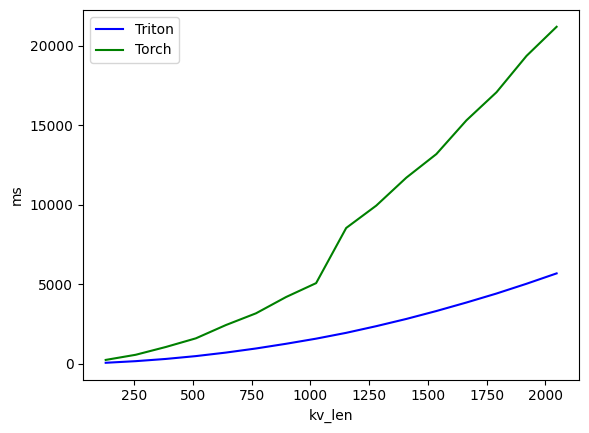

q_len = kv_len: prefill:
    kv_len       Triton         Torch
0    128.0    70.777774    250.842720
1    256.0   172.895983    574.897230
2    384.0   312.487036   1063.505292
3    512.0   490.819395   1608.174682
4    640.0   712.210596   2443.881989
5    768.0   970.037401   3180.700779
6    896.0  1265.305042   4204.276562
7   1024.0  1587.298632   5078.309059
8   1152.0  1953.173280   8545.232773
9   1280.0  2372.478724   9950.766563
10  1408.0  2826.461077  11706.684113
11  1536.0  3324.308872  13191.397667
12  1664.0  3859.338284  15311.419487
13  1792.0  4424.393654  17076.473236
14  1920.0  5039.500237  19364.929199
15  2048.0  5690.358639  21193.542480


In [12]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['kv_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="q_len = kv_len: prefill",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 2, 'num_head': 128, 'rope_head_dim': 64, 
              'nope_head_dim': 128, 'kv_lora_rank': 512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(kv_len, provider, bs, num_head, rope_head_dim, nope_head_dim, kv_lora_rank):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    q_len = kv_len
    scale = (rope_head_dim + nope_head_dim) ** (-0.5)
    q = torch.randn(bs, num_head, q_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
    k = torch.randn(bs, 1, kv_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
    v = torch.randn(bs, 1, kv_len, kv_lora_rank, device=device, dtype=dtype)
    k[..., :kv_lora_rank] = v
    attention_mask = torch.ones(bs, kv_len, device=device, dtype=torch.int32)
    attention_mask = None

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_mqa(q, k, v, scale, attention_mask=attention_mask))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_mqa(q, k, v, scale, attention_mask=attention_mask))
    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)

## decode

SM_COUNTS: 132


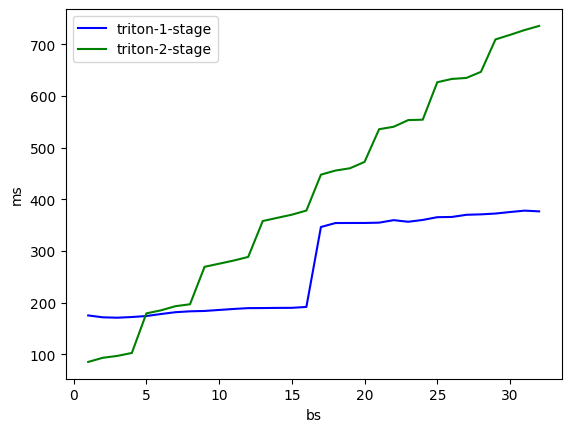

q_len = kv_len: prefill:
      bs  triton-1-stage  triton-2-stage
0    1.0      175.136000       85.100219
1    2.0      171.488166       93.088821
2    3.0      170.733750       96.734338
3    4.0      172.049060      102.462463
4    5.0      173.995927      179.080278
5    6.0      177.860916      184.999406
6    7.0      181.394160      193.034321
7    8.0      183.105052      196.778923
8    9.0      183.797300      269.268632
9   10.0      185.751140      275.304615
10  11.0      187.657520      281.383067
11  12.0      189.283058      288.441569
12  13.0      189.428121      357.932627
13  14.0      189.736441      364.126265
14  15.0      189.839348      370.229959
15  16.0      191.602260      378.218055
16  17.0      346.373200      447.759569
17  18.0      354.056716      455.698699
18  19.0      354.182452      460.142523
19  20.0      354.196489      472.486734
20  21.0      354.809910      535.745502
21  22.0      359.655261      540.527344
22  23.0      356.523186      55

In [7]:
sm_counts = torch.cuda.get_device_properties('cuda').multi_processor_count
print(f'SM_COUNTS: {sm_counts}')
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[i for i in range(1, 32+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['1-stage', '2-stage'],  # possible values for `line_arg``
        line_names=[
            "triton-1-stage",
            "triton-2-stage",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="q_len = kv_len: prefill",  # name for the plot. Used also as a file name for saving the plot.
        args={'kv_len': 4096, 'num_head': 128, 'rope_head_dim': 64, 
              'nope_head_dim': 128, 'kv_lora_rank': 512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(kv_len, provider, bs, num_head, rope_head_dim, nope_head_dim, kv_lora_rank):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    q_len = 1
    scale = (rope_head_dim + nope_head_dim) ** (-0.5)
    q = torch.randn(bs, num_head, q_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
    k = torch.randn(bs, 1, kv_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
    v = torch.randn(bs, 1, kv_len, kv_lora_rank, device=device, dtype=dtype)
    k[..., :kv_lora_rank] = v
    attention_mask = torch.ones(bs, kv_len, device=device, dtype=torch.int32)
    attention_mask = None

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == '1-stage':
        ms = triton.testing.do_bench(lambda: triton_mqa(q, k, v, scale, attention_mask=attention_mask, tow_stage_decode=False))
    if provider == '2-stage':
        ms = triton.testing.do_bench(lambda: triton_mqa(q, k, v, scale, attention_mask=attention_mask, tow_stage_decode=True))
    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)

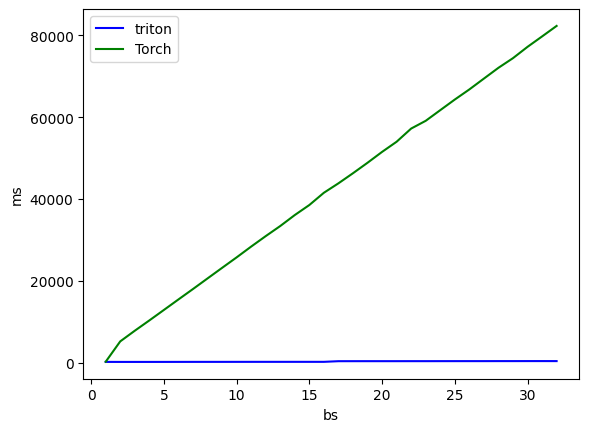

q_len = kv_len: prefill:
      bs      triton         Torch
0    1.0  176.043838    215.424657
1    2.0  171.237215   5192.801952
2    3.0  170.572832   7796.260834
3    4.0  172.148675  10311.325073
4    5.0  174.306512  12871.994972
5    6.0  178.015158  15439.877510
6    7.0  181.726381  17989.612579
7    8.0  183.423296  20577.903748
8    9.0  183.644727  23159.799576
9   10.0  186.694115  25723.711014
10  11.0  188.749000  28364.608765
11  12.0  190.305620  30920.587540
12  13.0  189.450711  33391.887665
13  14.0  191.128299  36076.850891
14  15.0  191.198498  38526.878357
15  16.0  191.305920  41523.166656
16  17.0  348.864406  43828.544617
17  18.0  352.297246  46296.928406
18  19.0  355.049968  48853.534698
19  20.0  353.810757  51512.737274
20  21.0  354.580879  53994.174957
21  22.0  357.973009  57215.934753
22  23.0  356.640041  59109.729767
23  24.0  361.275852  61713.375092
24  25.0  362.815708  64308.738708
25  26.0  365.141362  66779.838562
26  27.0  364.828408  69429.15

In [ ]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[i for i in range(1, 32+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="q_len = kv_len: prefill",  # name for the plot. Used also as a file name for saving the plot.
        args={'kv_len': 4096, 'num_head': 128, 'rope_head_dim': 64, 
              'nope_head_dim': 128, 'kv_lora_rank': 512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(kv_len, provider, bs, num_head, rope_head_dim, nope_head_dim, kv_lora_rank):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    q_len = 1
    scale = (rope_head_dim + nope_head_dim) ** (-0.5)
    q = torch.randn(bs, num_head, q_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
    k = torch.randn(bs, 1, kv_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
    v = torch.randn(bs, 1, kv_len, kv_lora_rank, device=device, dtype=dtype)
    k[..., :kv_lora_rank] = v
    attention_mask = torch.ones(bs, kv_len, device=device, dtype=torch.int32)
    attention_mask = None

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_mqa(q, k, v, scale, attention_mask=attention_mask))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_mqa(q, k, v, scale, attention_mask=attention_mask))
    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)

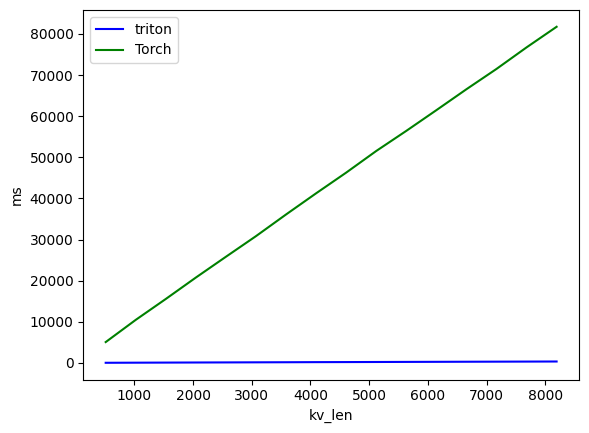

q_len = kv_len: prefill:
    kv_len      triton         Torch
0    512.0   35.938960   5071.476460
1   1024.0   60.133755  10475.356102
2   1536.0   83.111539  15558.148384
3   2048.0  104.651019  20764.736176
4   2560.0  125.070930  25820.671082
5   3072.0  147.124171  30834.890366
6   3584.0  167.608932  36103.088379
7   4096.0  192.112491  41248.401642
8   4608.0  207.200646  46277.503967
9   5120.0  227.741569  51537.822723
10  5632.0  249.469474  56429.279327
11  6144.0  268.690258  61461.791992
12  6656.0  290.033758  66552.543640
13  7168.0  308.453739  71489.440918
14  7680.0  327.018708  76727.836609
15  8192.0  347.484052  81739.807129


In [9]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['kv_len'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "triton",
            "Torch",
            
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="q_len = kv_len: prefill",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 16, 'num_head': 128, 'rope_head_dim': 64, 
              'nope_head_dim': 128, 'kv_lora_rank': 512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(kv_len, provider, bs, num_head, rope_head_dim, nope_head_dim, kv_lora_rank):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    q_len = 1
    scale = (rope_head_dim + nope_head_dim) ** (-0.5)
    q = torch.randn(bs, num_head, q_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
    k = torch.randn(bs, 1, kv_len, kv_lora_rank+rope_head_dim, device=device, dtype=dtype)
    v = torch.randn(bs, 1, kv_len, kv_lora_rank, device=device, dtype=dtype)
    k[..., :kv_lora_rank] = v
    attention_mask = torch.ones(bs, kv_len, device=device, dtype=torch.int32)
    attention_mask = None

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_mqa(q, k, v, scale, attention_mask=attention_mask))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_mqa(q, k, v, scale, attention_mask=attention_mask))
    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)